<a href="https://colab.research.google.com/github/surajbhala/GenAI/blob/main/Building_ReAct_AI_Agent_from_scratch_with_LangGraph_Part_1%2C2%2C3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install langchain==0.2.0
!pip install langchain-openai==0.1.7
!pip install langchain-community==0.2.0
!pip install langgraph==0.1.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.7/973.7 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.1/397.1 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.13
    Uninstalling langchain-core-0.3.13:
      Successfully uninstalled langchain-core-0.3.13
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitters 0.3.0
    Uninstalling langchain-text-splitters-0.3.0:
      Successfully uninstalled langchain-text-splitters-0.3.0
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.4
    Uninstalling langchain-0.3.4:
      Successfully uninstalled langchain-0.3.4
   ━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from getpass import getpass

In [3]:
openai_key = getpass("Enter your OpenAI API Key: ")

Enter your OpenAI API Key: ··········


In [4]:
tavily_api_key = getpass("Enter your Tavily API Key: ")

Enter your Tavily API Key: ··········


In [5]:
weather_api_key = getpass("Enter your Weather API Key: ")

Enter your Weather API Key: ··········


In [6]:
import os

os.environ['OPENAI_API_KEY'] = openai_key
os.environ['TAVILY_API_KEY'] = tavily_api_key
os.environ['WEATHER_API_KEY'] = weather_api_key

## Part 1: Build a Basic Chatbot with Langgraph

#### The first step will be to create a simple chatbot using LangGraph

### This chatbot will respond directly to user messages.
#### We will start by creating a `StateGraph`. A `StateGraph` object defines the structure of our chatbot as a "state machine"
#### `nodes` will represent llm and functions our chatbot can call
#### `edges` will specify how the bot should transition between these functions

In [7]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

class State(TypedDict):
    # Messages have the type "list"
    # The `add_messages` function in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

In [8]:
graph_builder = StateGraph(State)

We've defined our `State` as a TypedDict with a single key: `messages`.

The `messages` key is annotated with the [`add_messages`](https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages) function, which tells LangGraph to append new messages to the existing list, rather than overwriting it.

So now our graph knows two things:

1. Every `node` we define will receive the current `State` as input and return a value that updates that state.
2. `messages` will be _appended_ to the current list, rather than directly overwritten. This is communicated via the prebuilt [`add_messages`](https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages) function in the `Annotated` syntax.

Next, we add a "`chatbot`" node.

Nodes represent units of work. They are typically regular python functions.

This is a simple node which will just send our messages to an LLM.

In [9]:
from langchain_openai import ChatOpenAI

chatgpt = ChatOpenAI(model_name="gpt-3.5-turbo",temperature = 0)

def chatbot(state : State):
      return {"messages": [chatgpt.invoke(state["messages"])]}

# The first argument is the unique node name
# The second argument is the function or object
# this function will be called whenever the node is used.

graph_builder.add_node("chatbot",chatbot)

The `chatbot` node function takes the current `State` as input and returns an updated `messages` list.

This is the basic pattern for all LangGraph node functions.

The `add_messages` function in our `State` will append the LLM's response messages to whatever messages are already in the state.

Next, we add an `entry` point. This tells our graph **where to start its work** each time we run it.

In [10]:
graph_builder.set_entry_point("chatbot")

Similarly, we set a `finish` point. This instructs the graph **"any time this node is run, you can exit."**

In [11]:
graph_builder.set_finish_point("chatbot")

In [12]:
graph = graph_builder.compile()

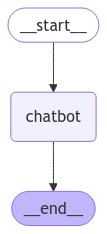

In [13]:
from IPython.display import Image, display, Markdown

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
prompt = """what is the capital of Nepal?"""
response = graph.invoke({"messages":("user",prompt)})
response

{'messages': [HumanMessage(content='what is the capital of Nepal?', id='14d76902-da58-41c3-9a58-2d553a812284'),
  AIMessage(content='The capital of Nepal is Kathmandu.', response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 14, 'total_tokens': 23, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-0b2ccd90-1c2a-4ad8-b2c6-743342b1cde8-0')]}

In [15]:
prompt = """What is langgraph?"""
response = graph.invoke({"messages":("user",prompt)})
display(Markdown(response['messages'][-1].content))

Langgraph is a tool used for visualizing and analyzing the relationships between languages. It can show how languages are related to each other through their historical development, geographical distribution, and linguistic features. Langgraph can help linguists and researchers better understand the connections between different languages and how they have evolved over time.

## Part II: Build a simple ReAct Agent with LangGraph - LLM + Tools

Now, we will build a simple ReAct agent in LangGraph which will use the web search or weather tool based on our input prompts to get relevant data which the LLM might not know by default and give relevant responses

We will showcase the following:

1. Building the agent completely from scratch
2. Leveraging LangGraph built-in node functions to build the agent faster

### Create Tools

Here we create two custom tools which are wrappers on top of the [Tavily API](https://tavily.com/#api) and [WeatherAPI](https://www.weatherapi.com/)

- Simple Web Search tool
- Weather tool

In [16]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
import json
import requests

tv_search = TavilySearchResults(max_results=3,search_depth = 'advanced',max_tokens= 10000)

@tool
def search_web(query: str) -> str:
    """Searches the web for the given input query."""
    results = tv_search.invoke(query)
    return results

@tool
def get_weather(location: str) -> str:
    """Gets the current weather for the given location."""
    base_url = "http://api.weatherapi.com/v1/current.json"
    complete_url = f"{base_url}?key={weather_api_key}&q={location}"
    response = requests.get(complete_url)

    data = response.json()
    if data.get("location"):
      return data
    else:
      return "Weather data not found"

### Building Agentic AI Functionality from Scratch

In [17]:
from typing import Annotated
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)
llm  = ChatOpenAI(model_name="gpt-3.5-turbo",temperature = 0)

tools = [search_web,get_weather]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
  return{"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot",chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")

We will now need to create a function to actually run the tools if they are called. We'll do this by adding the tools to a new node.

We implement a `BasicToolNode` that checks the most recent message in the state and calls tools if the message contains `tool_calls`.

It relies on the LLM's `tool_calling` support, which is available in Anthropic, OpenAI, Google Gemini, and a number of other LLM providers.

We will later replace this with LangGraph's prebuilt [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode) to speed things up, but building it from scratch gives us an idea of what happens under the hood

In [18]:
import json
from langchain_core.messages import ToolMessage

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools} # => {'search_web': search_web, 'get_weather': get_weather}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):  ## Walrus operator
            message = messages[-1] # get most recent message
        else:
            raise ValueError("No message found in input")
        outputs = []
        # if tool calls are mentioned by LLM in the most recent message
        # call the tool and get the result
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}
# add tool node to graph
tool_node = BasicToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

With the tool node added, we can define the `conditional_edges`.

Remember that **edges** route the control flow from one node to the next.

**Conditional edges** usually contain "if" statements to route to different nodes depending on the current graph state.

These functions receive the current graph `state` and return a string or list of strings indicating which node(s) to call next.

Below, we will define a router function called `route_tools`, that checks for `tool_calls` in the chatbot's output.

We provide this function to the graph by calling `add_conditional_edges`, which tells the graph that whenever the `chatbot` node completes to check this function to see where to go next.

The condition will route to `tools` if tool calls are present and "`__end__`" if not.

Later, we will replace this with the prebuilt [tools_condition](https://langchain-ai.github.io/langgraph/reference/prebuilt/#tools_condition) to be more concise, here we implement it from scratch to see what happens under the hood

In [19]:
from typing import Literal

def route_tools( state: State,) -> Literal["tools", "__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    # if state is a list of messages get the last one
    if isinstance(state, list):
        ai_message = state[-1]
    # if state is a dict, try to get the last message from the messages key
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    # if the last message is refering to a tool call, route to the tools node
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    # else route to end (stop the agent)
    return "__end__"

# The `tools_condition` function returns "tools"
# if the chatbot asks to use a tool,
# and "__end__" if it is fine directly responding and stopping the agent.
# This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools
)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
# set the entry point
graph_builder.set_entry_point("chatbot")
# compile the graph
graph = graph_builder.compile()

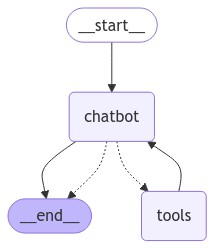

In [20]:
from IPython.display import Image, display, Markdown

display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
prompt = """What is the fastest animal on land?"""
response = graph.invoke({"messages": ("user", prompt)})
display(Markdown(response['messages'][-1].content))

The fastest animal on land is the cheetah. It is capable of going from 0 to 60 miles per hour in less than three seconds, making it the fastest land animal. However, the cheetah can maintain such high speeds only for short distances.

In [23]:
prompt = """What is LangGraph?"""
response = graph.invoke({"messages": ("user", prompt)})
display(Markdown(response['messages'][-1].content))

LangGraph is a framework for creating stateful, multi-actor applications with Large Language Models (LLMs). It utilizes cycles, controllability, and persistence. LangGraph can be used with LangChain, LangSmith, and Anthropic tools to build agent and multi-agent workflows.

You can learn more about LangGraph and how to use it by visiting the following links:
1. [LangGraph Official Website](https://langchain-ai.github.io/langgraph/)
2. [LangGraph Tutorial on DataCamp](https://www.datacamp.com/tutorial/langgraph-tutorial)
3. [LangGraph Tutorials](https://langchain-ai.github.io/langgraph/tutorials/)

### Build the Agentic Graph with LangGraph built-ins - Recommended Flow

Here we will use LangGraph to build the full graph which will have the Agentic workflow.

Each functionality will be implemented as we would in the real-world.

Here we will be replacing our `BasicToolNode` for the prebuilt [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode),
and our `route_tools` condition with the prebuilt [tools_condition](https://langchain-ai.github.io/langgraph/reference/prebuilt/#tools_condition)

In [24]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

# define function which will be used to store all agent messages
class State(TypedDict):
    messages: Annotated[list, add_messages]

# start the graph building
graph_builder = StateGraph(State)

# add tools and bind to LLM
tools = [search_web, get_weather]
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
llm_with_tools = llm.bind_tools(tools)

# add the LLM to graph
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

# Add tools to a node
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# add conditional edges
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    {'tools': 'tools', '__end__': '__end__'}
)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
# Define entry point to the graph
graph_builder.set_entry_point("chatbot")
# compile the graph
graph = graph_builder.compile()

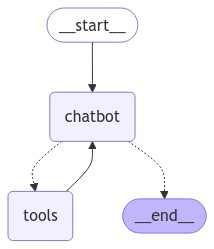

In [25]:
from IPython.display import Image, display, Markdown

display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
prompt = """What is the weather in Pune,India ?show detailed statistics"""
response = graph.invoke({"messages": ("user", prompt)})
display(Markdown(response['messages'][-1].content))

The current weather in Pune, India is as follows:
- Temperature: 24.7°C (76.4°F)
- Condition: Clear
- Wind: 3.6 km/h from the East
- Pressure: 1012.0 mb
- Humidity: 44%
- Visibility: 10.0 km
- Cloud Cover: 5%
- Feels like: 25.3°C (77.6°F)

Please let me know if you need more information or specific statistics.

In [28]:
prompt = """What is the weather in dubai? show detailed statistics"""
response = graph.invoke({"messages": ("user", prompt)})
display(Markdown(response['messages'][-1].content))

The current weather in Dubai is as follows:
- Temperature: 31.1°C (88.0°F)
- Condition: Sunny
- Wind: 16.9 km/h from the NW
- Pressure: 1014.0 mb
- Humidity: 55%
- Visibility: 10.0 km
- UV Index: 1.1

It feels like 34.1°C (93.4°F) with a wind chill of 29.3°C (84.8°F). The dewpoint is 19.2°C (66.6°F).

In [29]:
prompt = """Which city is hotter?"""
response = graph.invoke({"messages": ("user", prompt)})
display(Markdown(response['messages'][-1].content))

Sure, I can help you with that. Could you please provide me with the names of the two cities you would like to compare for their current weather?

## Part III: Build a multi-user conversational ReAct Agent with LangGraph

Now, we will build a multi-user conversational ReAct agent with LangGraph which will use the web search or weather tool based on our input prompts to get relevant data which the LLM might not know by default and give relevant responses

Our agentic chatbot from Part II can use tools to answer user questions, but it doesn't remember the context of previous interactions. This limits its ability to have coherent, multi-turn conversations.

LangGraph solves this problem through **persistent checkpointing**. If you provide a `checkpointer` when compiling the graph and a `thread_id` when calling your graph, LangGraph automatically saves the state after each step. When you invoke the graph again using the same `thread_id`, the graph loads its saved state, allowing the chatbot to pick up where it left off.

**checkpointing** is _much_ more powerful than simple chat memory - it lets you save and resume complex state at any time for error recovery, human-in-the-loop workflows, time travel interactions, and more

While the legacy syntax uses `session_id`, in LangGraph, each user session is identified by `thread_id`

We will use `SqliteSaver` which helps to store separate conversation histories per user or session.

This will help us build a conversational Agentic Chatbot which will be accessed by many users at the same time.



In [30]:
# removes the memory database file - usually not needed
# you can run this only when you want to remove ALL conversation histories
# ok if you get rm: cannot remove 'memory.db': No such file or directory  because initially no memory exists
!rm memory.db*

rm: cannot remove 'memory.db*': No such file or directory


In [ ]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.sqlite import SqliteSaver

# used to retrieve conversation history from database
# based on a specific user or session ID  - thread_id
memory = SqliteSaver.from_conn_string("memory.db")

# define function which will be used to store all agent messages
class State(TypedDict):
    messages: Annotated[list, add_messages]

# start the graph building
graph_builder = StateGraph(State)

# add tools and bind to LLM
tools = [search_web, get_weather]
llm = ChatOpenAI(model="gpt-4o", temperature=0)
llm_with_tools = llm.bind_tools(tools)

# add the LLM to graph
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

# Add tools to a node
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# add conditional edges
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    # either goes to tool node if tool calls or else end node
    {'tools': 'tools', '__end__': '__end__'}
)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
# Define entry point to the graph
graph_builder.set_entry_point("chatbot")
# compile the graph - Add the memory here
graph = graph_builder.compile(checkpointer=memory)